# SVC (Support Vector Classification)
In this notebook I will demonstrate how to use svc to build a classifier for car and non-car.

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import os
import pickle
from feature_extraction import extract_features_from_file_list
from config import feature_extraction_params

### Parsing annotation
I have to cropped image which annotation providing so that SVC will get better accuricy.

In [2]:
from lxml import etree
import tensorflow as tf

def xml_to_dict(xml):
    if len(xml) == 0:
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = xml_to_dict(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

def fetch_bbox(xml_path):
    with tf.gfile.GFile(xml_path, 'r') as fid:
        xml_str = fid.read()
    xml = etree.fromstring(xml_str)
    dict_data = xml_to_dict(xml)['annotation']['object']
    bboxes = [(int(bbox['bndbox']['xmin']), int(bbox['bndbox']['ymin']), 
               int(bbox['bndbox']['xmax']), int(bbox['bndbox']['ymax']), np.uint8(bbox['name']=='car')) for bbox in dict_data]
    
    return bboxes

### Loading dataset
The dataset comes from [VOC2007]('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/') and I will use this for training SVC used to classify cars or non-cars.

In [3]:
import matplotlib.image as mpimg
import pandas as pd

path_of_trainset_info = os.path.join('../', 'data', 'VOCdevkit', 'VOC2007', 'ImageSets', 'Main', 'car_trainval.txt')
path_of_trainset_image_dir = os.path.join('../', 'data', 'VOCdevkit', 'VOC2007', 'JPEGImages')
path_of_annotaion_dir = os.path.join('../', 'data', 'VOCdevkit', 'VOC2007', 'Annotations')

def load_trainset_data(trainset_info, trainset_image_dir):
    trdf = pd.read_csv(trainset_info, delim_whitespace=True, 
                   names=['uri', 'label'], dtype={'uri': np.str, 'label': np.int8})
    imgs = []
    labels = []
    uris = []
    for uri, label in trdf.as_matrix():
        if label == 1:
            bboxes = fetch_bbox(os.path.join(path_of_annotaion_dir, '{}.xml'.format(uri)))
            for xmin, ymin, xmax, ymax, label in bboxes: 
                img_uri = os.path.join(trainset_image_dir, '{}.jpg'.format(uri))
                img = mpimg.imread(img_uri)
                img = img[ymin:ymax, xmin:xmax]
                imgs.append(img)
                labels.append(label)
                uris.append(img_uri)
        else:
            img_uri = os.path.join(trainset_image_dir, '{}.jpg'.format(uri))
            img = mpimg.imread(img_uri)
            label = np.int8(label>0)
            imgs.append(img)
            labels.append(label)
            uris.append(img_uri)
    imgs = np.array(imgs)
    labels = np.array(labels, dtype=np.uint8)
    uris = np.array(uris)
    
    return imgs, labels, uris

imgs, labels, uris = load_trainset_data(path_of_trainset_info, path_of_trainset_image_dir)

### Split data into training and testing set
In machine learning, we must to split preprocessing data into training and testing set in order to get accuracy of model.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, z_train_uris, z_test_uris = train_test_split(imgs, labels, uris, test_size=0.2, shuffle=True)

extract features incuding hog, histogram, and spatial of each color channels in images. <br/>
Furthermore, lets use StandardScaler to standarize dataset for preventing from got effection by some big portion of information in dataset.

In [5]:
X_features = extract_features_from_file_list(imgs, feature_extraction_params)
X_train_features = extract_features_from_file_list(X_train, feature_extraction_params)
X_test_features = extract_features_from_file_list(X_test, feature_extraction_params)


feature_scaler = StandardScaler().fit(X_features)
scaled_X = feature_scaler.transform(X_train_features)
scaled_X_test = feature_scaler.transform(X_test_features)

/home/jameschien/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Train SVC
we use 'rbf'(radio basis function) kernel to train model. Very easy to use, right?

In [6]:
svc = LinearSVC()
svc.fit(scaled_X, y_train)
print('Test Accuracy of SVC = ', round(svc.score(scaled_X_test, y_test), 4))

Test Accuracy of SVC =  0.839


### (Optional) Demonstration Time

../data/VOCdevkit/VOC2007/JPEGImages/008351.jpg
../data/VOCdevkit/VOC2007/JPEGImages/001777.jpg
../data/VOCdevkit/VOC2007/JPEGImages/009920.jpg
../data/VOCdevkit/VOC2007/JPEGImages/001775.jpg


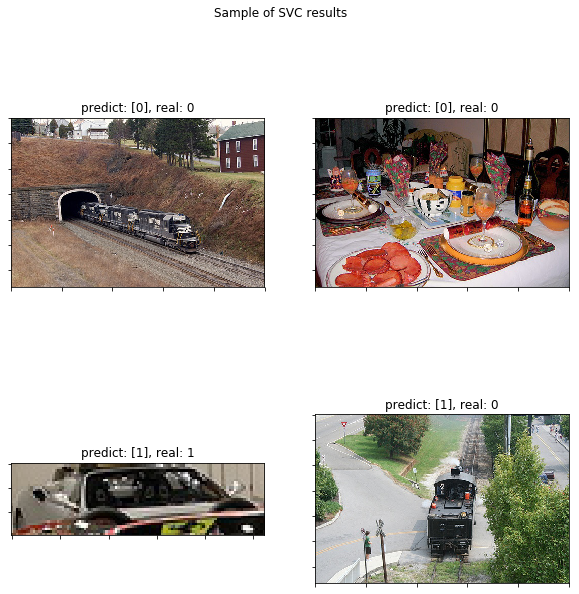

In [10]:
import random

car_idx = y_test == 1
fig, ax_array = plt.subplots(2, 2, figsize=(10, 10))

for ax in ax_array.ravel():
    rid = random.randint(0, y_test.shape[0]-1)
    _y = svc.predict([scaled_X_test[rid]])
    ax.set_title("predict: {}, real: {}".format(_y, y_test[rid]))
    ax.imshow(X_test[rid])
    print(z_test_uris[rid])

if not os.path.exists('output_image'):
    os.makedirs('output_image')
    
plt.suptitle("Sample of SVC results")
plt.setp([ax.get_xticklabels() for ax in ax_array.ravel()], visible=False)
plt.setp([ax.get_yticklabels() for ax in ax_array.ravel()], visible=False)
plt.savefig(os.path.join('output_image', 'sample_svc.jpg'))
plt.show()

### Saving SVC and StandardFeatures to pickle file

In [8]:
if not os.path.exists('weights'):
    os.makedirs('weights')
pickle.dump(svc, open('weights/svc_car.pickle', 'wb'))
pickle.dump(feature_scaler, open('weights/feature_scaler.pickle', 'wb'))